## EDA - Влияние условий жизни учеников на успеваемость по математике

Суть проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

Требуется проанализировать и преобразовать входящие данные, для того чтобы в будущем их можно бы было использовать в модели предсказания. 

Работа состоит из следующих этапов:
* Первоначальная загрузка и очистка значений
* Анализ и очистка количественных данных от выбросов и взаимно-коррелируемых признаков
* Проверка статистических различий итогого бала для номинативных признаков
* Форм

## Импорт библиотек и загрузка датасета

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

In [5]:
ds = pd.read_csv('stud_math.csv')

## Первоначальный осмотр датасета

In [6]:
display(ds.head(10))
ds.info()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

**Предварительные выводы**: Во всех колонках кроме трех есть какое-то количество пустых значений. Т.к. мы предсказываем score - удалим строки с пустым score

In [7]:
ds.dropna(subset=["score"], inplace=True)

Перееименуем колонки ради лучшей читаемости и самоописания, а также сохраним количественные и номинативные колонки в отдеельные переменные для дальнейшего удобства

In [8]:
ds.columns = ['school', 'sex', 'age', 'address', 'family_size', 'parents_status', 'mother_education', 'father_education',
              'mother_job', 'father_job', 'school_choice_reason', 'guardian', 'commute_time', 'homework_time',
              'failures', 'school_support', 'family_support', 'paid_tutor', 'activities', 'pre_school',
              'homework_time_granular', 'college_plan', 'internet_access', 'in_relationship', 'family_climate',
              'free_time', 'out_time', 'health', 'absence', 'score']


categorical_cols = ['school', 'sex', 'address', 'family_size', 'parents_status',
                    'mother_job', 'father_job', 'school_choice_reason', 'guardian',
                    'school_support', 'family_support', 'paid_tutor', 'activities', 'pre_school', 'college_plan', 'internet_access', 'in_relationship'
                    ]

numerical_cols = ['age', 'commute_time', 'homework_time', 'failures', 'score', 'mother_education', 'father_education',
                  'homework_time_granular', 'family_climate', 'free_time', 'out_time', 'health', 'absence']

## Проверка значений на частоту и чистоту

Просмотрим уникальные значения во всех колонках чтобы понять кардинальность, а также увидеть неожиданные и пустые данные

In [9]:
for c in ds:
    display(pd.DataFrame(ds[c].value_counts()))

,school
GP,344
MS,45


,sex
F,204
M,185


,age
16,103
17,98
15,82
18,80
19,21
20,3
22,1
21,1


,address
U,291
R,83


,family_size
GT3,255
LE3,107


,parents_status
T,308
A,36


,mother_education
4.0,131
2.0,100
3.0,96
1.0,56
0.0,3


,father_education
2.0,105
3.0,94
4.0,88
1.0,75
0.0,2
40.0,1


,mother_job
other,127
services,98
at_home,58
teacher,55
health,32


,father_job
other,194
services,99
teacher,29
at_home,16
health,15


,school_choice_reason
course,135
reputation,102
home,101
other,34


,guardian
mother,248
father,86
other,24


,commute_time
1.0,239
2.0,94
3.0,21
4.0,7


,homework_time
2.0,189
1.0,103
3.0,63
4.0,27


,failures
0.0,290
1.0,48
2.0,15
3.0,14


,school_support
no,331
yes,49


,family_support
yes,216
no,135


,paid_tutor
no,197
yes,153


,activities
yes,192
no,183


,pre_school
yes,297
no,77


,homework_time_granular
-6.0,189
-3.0,103
-9.0,63
-12.0,27


,college_plan
yes,350
no,19


,internet_access
yes,300
no,55


,in_relationship
no,235
yes,123


,family_climate
4.0,178
5.0,97
3.0,62
2.0,17
1.0,7
-1.0,1


,free_time
3.0,152
4.0,110
2.0,63
5.0,37
1.0,18


,out_time
3.0,126
2.0,101
4.0,81
5.0,51
1.0,23


,health
5.0,137
3.0,88
4.0,60
1.0,47
2.0,42


,absence
0.0,110
2.0,60
4.0,52
6.0,30
8.0,20
10.0,17
12.0,12
14.0,12
3.0,7
16.0,7


,score
50.0,54
55.0,46
0.0,37
75.0,33
65.0,31
40.0,31
60.0,31
70.0,27
45.0,27
80.0,16


**Предварительные выводы**:

_family_climate_ - отрицательные значения (-1)

_father_education_ - ошибочное значение 40

_absence_ - 385.0 выглядит подозрительно, возможно данные больше чем за 1 год, но мы также видим что 111 человек имеет 0 пропусков, что с точки зрения здравого смысла трудно достижимо с увеличеним числа годов.

Сами значения чистые и нет необходимости их преобразовывать

## Анализ количественных признаков - выбросы

### Вспомогательные функции

In [32]:
def draw_hists(full_series, outliers, col):
    fig = plt.figure()
    main_axes = fig.add_axes([0, 0, 0.5, 0.5])
    iqr_axes = fig.add_axes([0.8, 0, 0.5, 0.5])
    main_axes.hist(full_series)
    main_axes.set_xlabel(col + ' distribution')
    iqr_axes.hist(outliers)
    iqr_axes.set_xlabel('IQR')
    plt.show()


def describe_numerical(col):
    print(ds[col].describe())

    median = ds[col].median()
    perc25 = ds[col].quantile(0.25)
    perc75 = ds[col].quantile(0.75)
    IQR = perc75 - perc25
    outliers = (perc25 - 1.5*IQR, perc75 + 1.5*IQR)
    print(f'IQR: {IQR}\nГраницы выбросов: {outliers}')

    draw_hists(ds[col], ds[col].loc[ds[col].between(
        outliers[0], outliers[1])], col)

### Строим графики распределения и выбросов

count    173.000000
mean      16.549133
std        1.080569
min       15.000000
25%       16.000000
50%       16.000000
75%       17.000000
max       20.000000
Name: age, dtype: float64
IQR: 1.0
Границы выбросов: (14.5, 18.5)


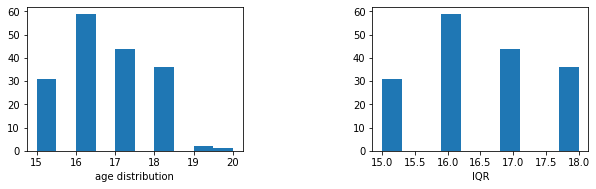

count    173.000000
mean       1.387283
std        0.585940
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        3.000000
Name: commute_time, dtype: float64
IQR: 1.0
Границы выбросов: (-0.5, 3.5)


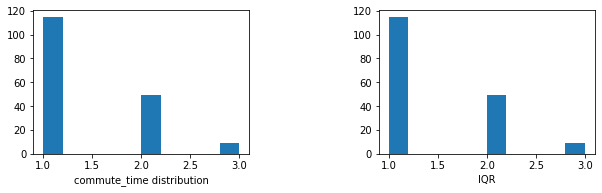

count    173.000000
mean       1.919075
std        0.677148
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        3.000000
Name: homework_time, dtype: float64
IQR: 1.0
Границы выбросов: (-0.5, 3.5)


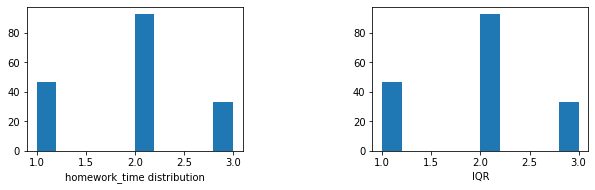

count    173.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: failures, dtype: float64
IQR: 0.0
Границы выбросов: (0.0, 0.0)


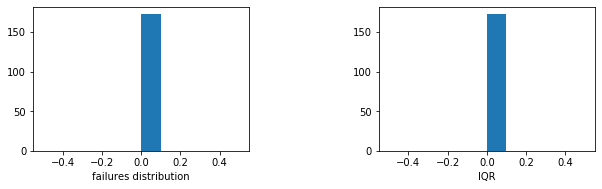

count    173.000000
mean      55.578035
std       18.908008
min        0.000000
25%       50.000000
50%       55.000000
75%       70.000000
max       95.000000
Name: score, dtype: float64
IQR: 20.0
Границы выбросов: (20.0, 100.0)


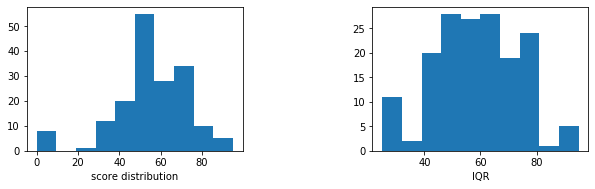

count    171.000000
mean       2.859649
std        1.102488
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: mother_education, dtype: float64
IQR: 2.0
Границы выбросов: (-1.0, 7.0)


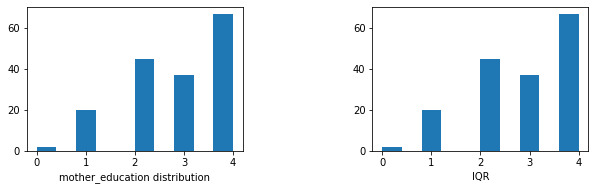

count    173.000000
mean       2.699422
std        1.046506
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: father_education, dtype: float64
IQR: 2.0
Границы выбросов: (-1.0, 7.0)


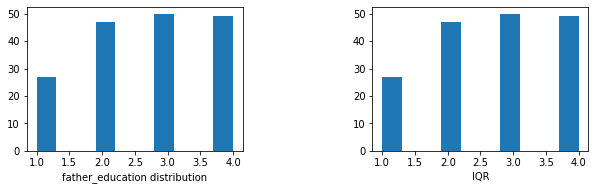

KeyError: 'homework_time_granular'

In [33]:
for c in numerical_cols:
    describe_numerical(c)

Удаляем обнаруженные выбросы из выборки:

commute_time > 3.5

homework_time > 3.5

father_education > 7

family_climate < 2.5

free_time < 1.5

absence > 20

In [12]:
ds = ds.loc[(ds.commute_time <= 3.5) &
            (ds.homework_time <= 3.5) &
            (ds.failures == 0) &
            (ds.father_education <= 7) &
            (ds.family_climate >= 2.5) &
            (ds.free_time >= 1.5) &
            (ds.absence <= 20)]

75 персентиль значений failures = 0 и это превращает все остальные значения в выбросы, хоть их и достаточно много. Пока не удалять эти значения, до проверки корелляции со score

In [13]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 173 entries, 0 to 394
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   school                  173 non-null    object 
 1   sex                     173 non-null    object 
 2   age                     173 non-null    int64  
 3   address                 168 non-null    object 
 4   family_size             165 non-null    object 
 5   parents_status          157 non-null    object 
 6   mother_education        171 non-null    float64
 7   father_education        173 non-null    float64
 8   mother_job              166 non-null    object 
 9   father_job              164 non-null    object 
 10  school_choice_reason    164 non-null    object 
 11  guardian                157 non-null    object 
 12  commute_time            173 non-null    float64
 13  homework_time           173 non-null    float64
 14  failures                173 non-null    fl

## Анализ количественных признаков - Корреляции

In [14]:
ds.corr()

,age,mother_education,father_education,commute_time,homework_time,failures,homework_time_granular,family_climate,free_time,out_time,health,absence,score
age,1.000000,-0.136020,-0.130822,0.213111,0.061086,NaN,-0.061086,-0.002623,-0.128554,0.120856,-0.079858,0.120614,-0.170711
mother_education,-0.136020,1.000000,0.659023,-0.096176,0.088021,NaN,-0.088021,0.120681,0.042230,0.050717,0.066699,0.140647,0.122231
father_education,-0.130822,0.659023,1.000000,-0.065055,0.014702,NaN,-0.014702,0.033204,-0.019250,-0.006863,0.157090,0.092938,0.132237
commute_time,0.213111,-0.096176,-0.065055,1.000000,-0.125696,NaN,0.125696,-0.051714,-0.002421,-0.049317,-0.000619,-0.096514,-0.007204
homework_time,0.061086,0.088021,0.014702,-0.125696,1.000000,NaN,-1.000000,0.104580,-0.053815,0.076582,-0.067754,-0.114060,0.019568
failures,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
homework_time_granular,-0.061086,-0.088021,-0.014702,0.125696,-1.000000,NaN,1.000000,-0.104580,0.053815,-0.076582,0.067754,0.114060,-0.019568
family_climate,-0.002623,0.120681,0.033204,-0.051714,0.104580,NaN,-0.104580,1.000000,0.126265,0.007489,-0.010504,-0.047038,0.051501
free_time,-0.128554,0.042230,-0.019250,-0.002421,-0.053815,NaN,0.053815,0.126265,1.000000,0.114048,0.012694,0.071698,0.082642
out_time,0.120856,0.050717,-0.006863,-0.049317,0.076582,NaN,-0.076582,0.007489,0.114048,1.000000,-0.058186,0.120254,-0.226295


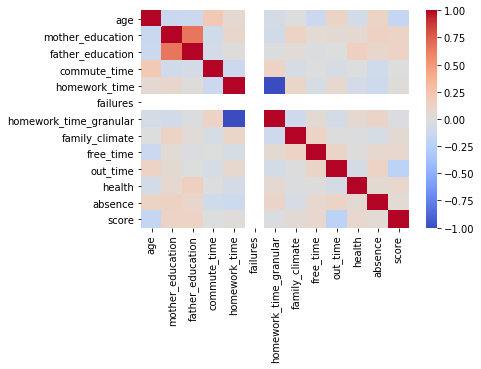

In [15]:
sns.heatmap(ds.corr(), cmap='coolwarm')

homework_time_granular обратно-кореллирует с homework_time поэтому удаляем этот признак

In [16]:
ds.drop(['homework_time_granular'], inplace=True, axis=1)

## Анализ номинативных признаков

Строим вспомогательные графики распределений score по значениям номинативных признаков

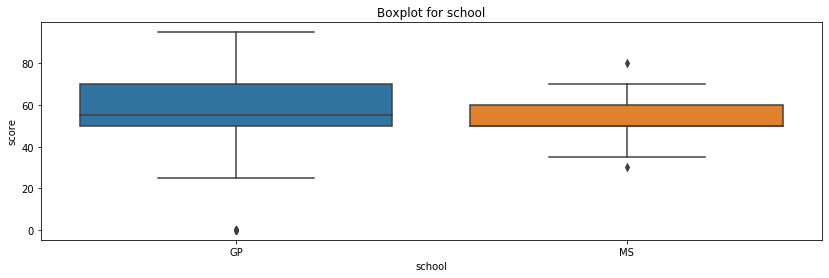

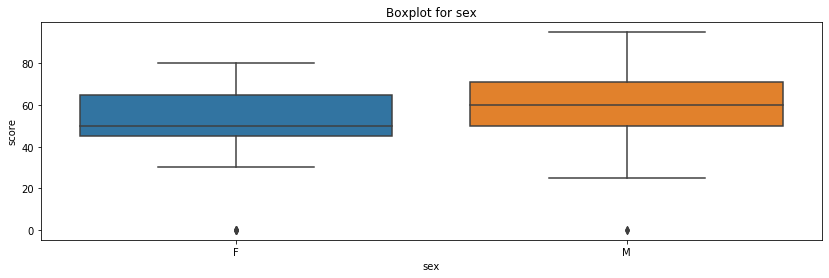

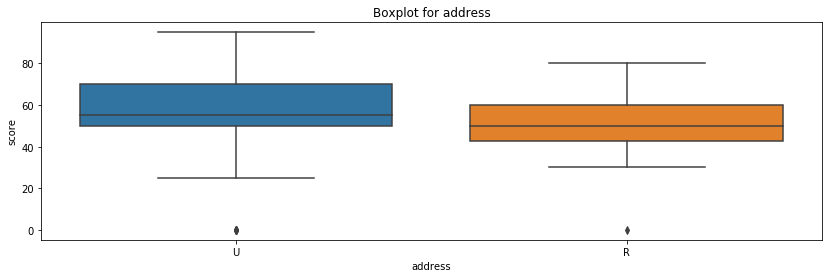

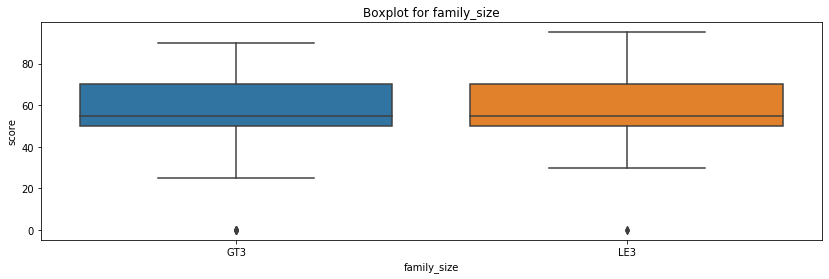

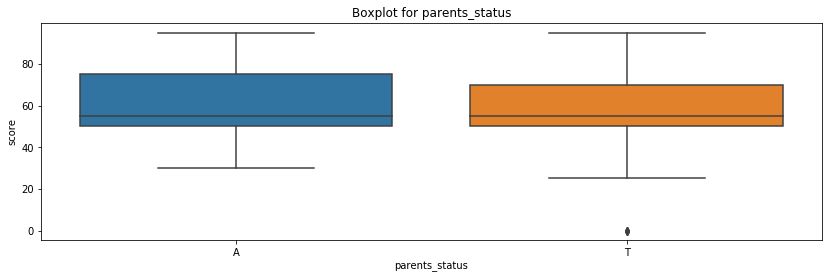

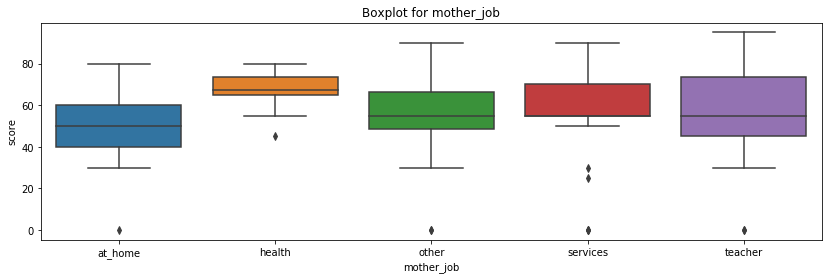

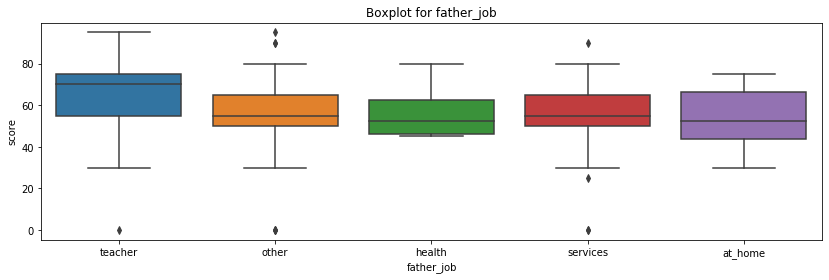

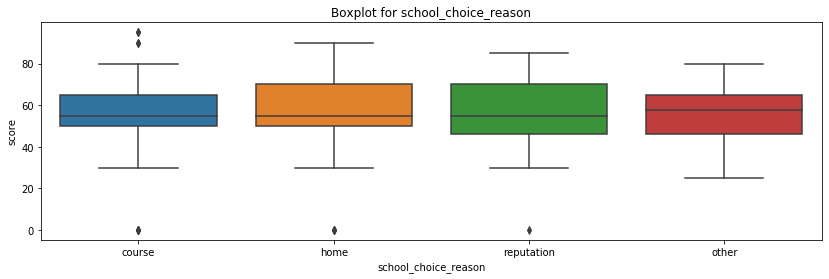

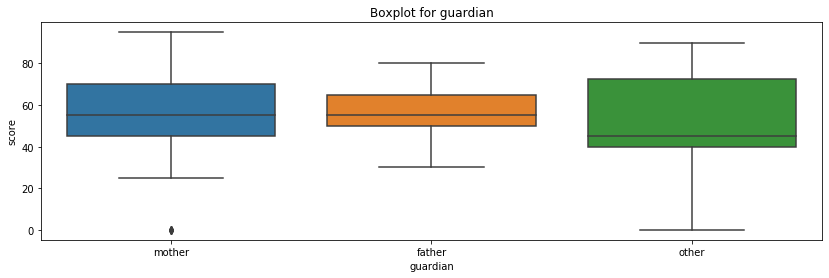

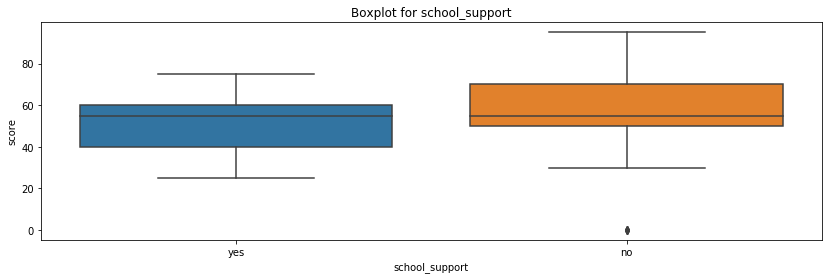

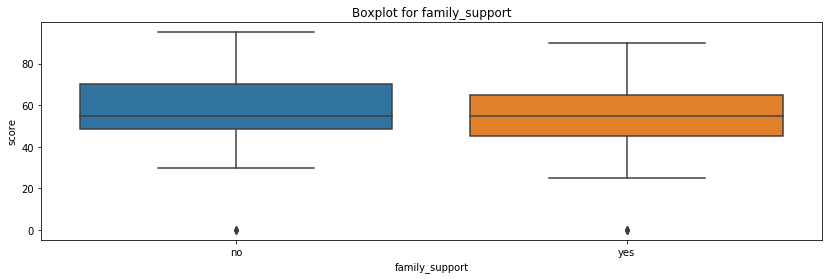

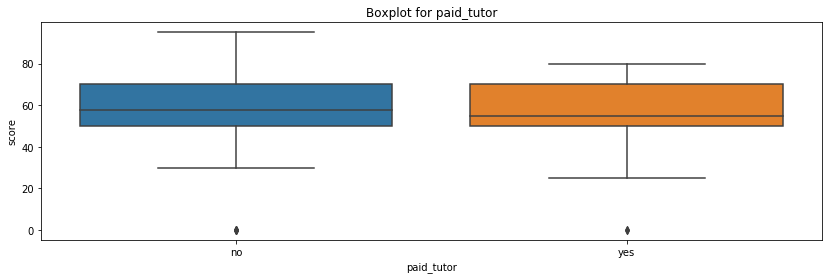

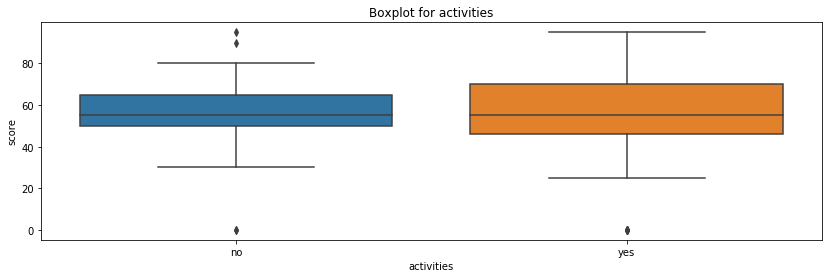

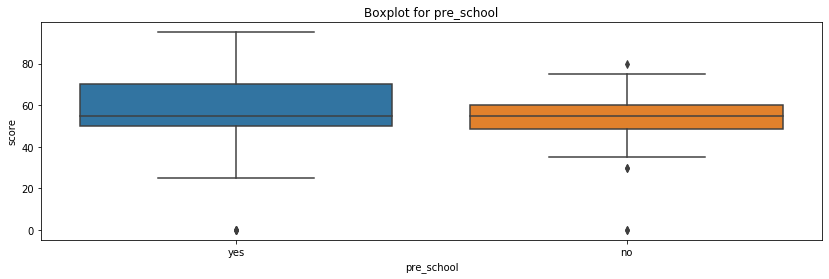

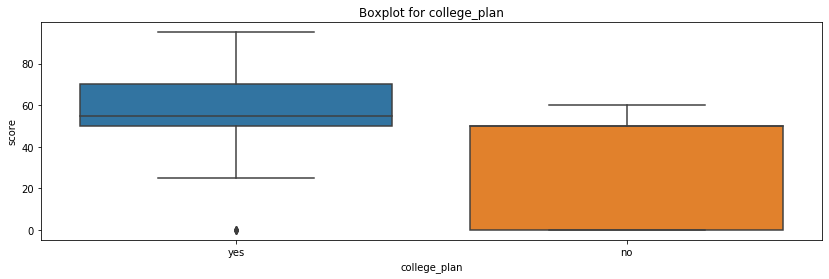

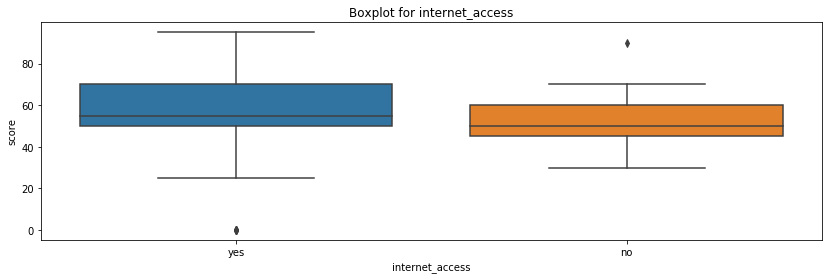

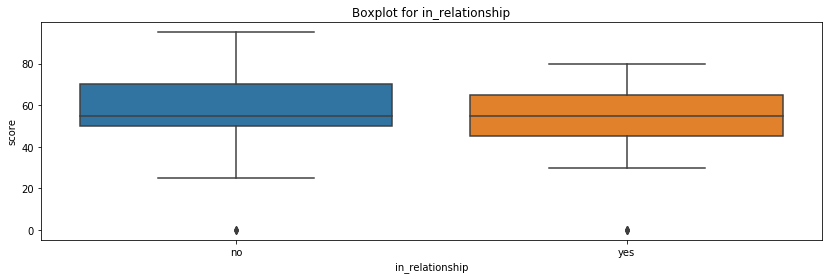

In [17]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='score',
                data=ds.loc[ds.loc[:, column].isin(
                    ds.loc[:, column].value_counts().index[:10])],
                ax=ax)
    ax.set_title('Boxplot for ' + column)
    plt.show()


for col in categorical_cols:
    get_boxplot(col)

**Предварительный вывод**: все признаки кроме family_size как-то влияют на значение score. 

Проверяем есть ли статистическая разница в распределение score по каждой паре признаков с помощью теста Стьюдента. Нулевая гипотеза: распределение score по параметрам неразличимы: 

In [18]:
def get_stat_dif(column):
    cols = ds.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(ds.loc[ds.loc[:, column] == comb[0], 'score'],
                     ds.loc[ds.loc[:, column] == comb[1], 'score']).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [19]:
for col in categorical_cols:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки mother_job
Найдены статистически значимые различия для колонки college_plan


Удаляем остальные номинативные признаки:

In [20]:
ds.drop([c for c in categorical_cols if c not in [
        'sex', 'mother_job', 'colege_plan']], inplace=True, axis=1)

### Итоговые выводы

В результате EDA по влиянию условий жизни учеников на итоговый экзаменационный бал по математике были получены следующией выводы:

* Входные данные были чистые, без необходимости преобразования
* Во всех колонках было мало пустых значений
* Много численных признаков
 * Из 6 из них мы удалили выбросы
 * 2 Признака сильно коррелировали между собой и один из них был удален (homework_time_granular)
* Значения всего 3х номинативных признаков sex, mother_job, college_plan давали статистические значимые различия 
* Параметры которые предлагается использовать для модели это колонки финальной выборки ниже

In [21]:
display(ds)

,sex,age,mother_education,father_education,mother_job,commute_time,homework_time,failures,family_climate,free_time,out_time,health,absence,score
0,F,18,4.0,4.0,at_home,2.0,2.0,0.0,4.0,3.0,4.0,3.0,6.0,30.0
1,F,17,1.0,1.0,at_home,1.0,2.0,0.0,5.0,3.0,3.0,3.0,4.0,30.0
3,F,15,4.0,2.0,health,1.0,3.0,0.0,3.0,2.0,2.0,5.0,2.0,75.0
4,F,16,3.0,3.0,other,1.0,2.0,0.0,4.0,3.0,2.0,5.0,4.0,50.0
5,M,16,4.0,3.0,services,1.0,2.0,0.0,5.0,4.0,2.0,5.0,10.0,75.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382,M,17,2.0,3.0,other,2.0,2.0,0.0,4.0,4.0,3.0,3.0,2.0,50.0
386,F,18,4.0,4.0,teacher,3.0,1.0,0.0,4.0,4.0,3.0,5.0,7.0,30.0
388,F,18,3.0,1.0,teacher,1.0,2.0,0.0,4.0,3.0,4.0,1.0,0.0,40.0
393,M,18,3.0,2.0,services,3.0,1.0,0.0,4.0,4.0,1.0,5.0,0.0,50.0
